In [80]:
import os
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt

from PIL import Image

import tensorflow as tf
import numpy as np

In [81]:
os.getcwd()
os.chdir('C:\\Users\\corne\\OneDrive\\Documents\\DS_Portfolio\\style_transfer')
os.getcwd()

'C:\\Users\\corne\\OneDrive\\Documents\\DS_Portfolio\\style_transfer'

## Content Image

Content image shape:
(300, 300, 3)
Content Image:


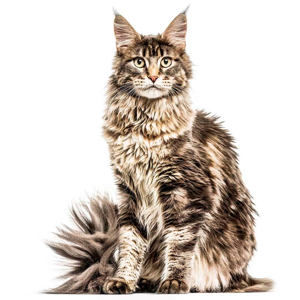

In [82]:
#content image

#Defining function to look at a digit
def show_num(input_pic):
  plt.imshow(input_pic,cmap='binary')
  plt.axis(False)

content_image = Image.open('Maine-Coon-Cat.webp')
aspect_ratio = np.array(content_image).shape[0]/np.array(content_image).shape[1]
content_image = content_image.resize((300, int(300*aspect_ratio)))
print('Content image shape:')
print(np.array(content_image).shape)
print('Content Image:')
content_image
#[Purina](https://www.purina.co.uk/find-a-pet/cat-breeds/maine-coon)

In [83]:
#content image formatting 
print('Content image formatting:')
print(f'Original size: {content_image.size}')

#converting to tensor
content_image = np.array(content_image)/255
content_image = content_image[None,:,:,:]
print((f'Tensor size: {content_image.shape}'))

Content image formatting:
Original size: (300, 300)
Tensor size: (1, 300, 300, 3)


## Style Image

In [84]:
style_image = Image.open('bob-ross.webp')

print('Style image formatting:')
print(f'Original size: {style_image.size}')

#resizing, preserving aspect ratio
style_image = style_image.resize((int(320*1024/791),320))
#print(f'Size after resizing: {style_image.size}')

#cropping
style_image = style_image.crop((10,10,310,310)) #left, upper, right, lower
print(f'Size after cropping: {style_image.size}')

#converting to tensor
style_image = np.array(style_image)/255
style_image = style_image[None,:,:,:]
print((f'Tensor size: {style_image.shape}'))

Style image formatting:
Original size: (1024, 791)
Size after cropping: (300, 300)
Tensor size: (1, 300, 300, 3)


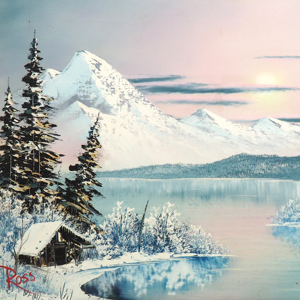

In [85]:
#visualizing adjusted style image 

def show_tensor(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8) 
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

#[Bob ross painting](https://modernartifact.com/products/bob-ross-rare-signed-original-arctic-winter-day-18-x-24-oil-on-canvas-painting#gallery-1)
show_tensor(style_image)

## Loading VGG Neural Network

In [86]:
vgg = tf.keras.applications.VGG19(include_top=False,
                                  input_shape=(content_image.shape[1], content_image.shape[2], 3),
                                  weights='imagenet')
vgg.trainable = False

for layer in vgg.layers:
    print(layer.name)

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [87]:
STYLE_LAYERS = [
    ('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2)]

In [88]:
def get_layer_outputs(vgg, layer_names):
    outputs = [vgg.get_layer(layer[0]).output for layer in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    return model

In [89]:
content_layer = [('block3_conv4', 1)]

vgg_model_outputs = get_layer_outputs(vgg, STYLE_LAYERS + content_layer)

content_target = vgg_model_outputs(content_image)  # Content encoder
style_targets = vgg_model_outputs(style_image)     # Style encoder

## Cost functions

In [90]:
# compute content cost
def compute_content_cost(content_ouput, generated_output):
    a_C = content_ouput[-1]
    a_G = generated_output[-1]
    
    #a_G dimensions
    _, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    #reshape
    a_C_unrolled = tf.reshape(a_C, shape = [_,-1, n_C])
    a_G_unrolled = tf.reshape(a_G, shape = [_, -1, n_C])
    
    #cost 
    J_content = tf.reduce_sum((a_C-a_G)**2/(4*n_H*n_W*n_C))
    
    return J_content

In [91]:
def compute_layer_style_cost(a_S, a_G):
    _, n_H, n_W, n_C = a_G.get_shape()
    a_S = tf.transpose(tf.reshape(a_S, shape=[n_H*n_W,n_C]))
    a_G = tf.transpose(tf.reshape(a_G, shape=[n_H*n_W,n_C]))
    
    GS = tf.matmul(a_S, tf.transpose(a_S))
    GG = tf.matmul(a_G, tf.transpose(a_G))
    
    J_style_layer = tf.reduce_sum(tf.square(tf.subtract(GS,GG)))/(4*n_C**2*((n_H*n_W)**2))
    
    return J_style_layer

In [92]:
def compute_style_cost(style_image_output, generated_image_output, STYLE_LAYERS=STYLE_LAYERS):
    J_style = 0
    
    a_S = style_image_output[:-1]
    a_G = generated_image_output[:-1]
    
    for i, weight in zip(range(len(a_S)), STYLE_LAYERS):  
        J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])
        J_style += weight[1] * J_style_layer

    return J_style

## Defining initial generated image

In [93]:
preprocessed_content =  tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
a_C = vgg_model_outputs(preprocessed_content)
preprocessed_style =  tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))
a_S = vgg_model_outputs(preprocessed_style)

In [94]:
def clip_me(image):
    return tf.clip_by_value(image, 0.0, 1.0)

Checking size of generated image: (1, 300, 300, 3)


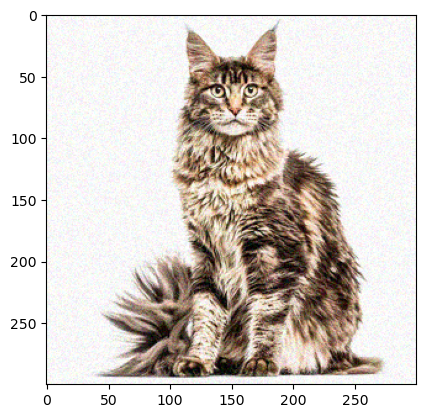

In [95]:
#initialize image to be geenrated 
#generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
noise = tf.random.uniform(tf.shape(content_image),-.1,.1)
generated_image = content_image + noise
generated_image = clip_me(generated_image)
generated_image = tf.Variable(generated_image)
print(f'Checking size of generated image: {generated_image.get_shape()}')

  
image_check = show_tensor(generated_image)
plt.imshow(image_check)

## Minimizing Cost Function

In [96]:
@tf.function()
def total_cost(J_content, J_style, alpha = 10,beta = 50):
    J = alpha*J_content+beta*J_style
    return J

In [105]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)

@tf.function()
def train_step(generated_image):
    with tf.GradientTape() as tape:
        
        a_G = vgg_model_outputs(generated_image)
        
        J_style = compute_style_cost(a_S, a_G)
        J_content = compute_content_cost(a_C, a_G)

        J = total_cost(J_content, J_style)
          
    grad = tape.gradient(J, generated_image)

    optimizer.apply_gradients([(grad, generated_image)])
    
    generated_image.assign(clip_me(generated_image))   
    return J

## Training model

In [106]:
# Show the generated image at some epochs
# Uncomment to reset the style transfer process. You will need to compile the train_step function again 
epochs = 10
for i in range(epochs):
    train_step(generated_image)
    if i % 10 == 0:
        print(f'Epoch {i} - Img')
        show_tensor(generated_image)

Epoch 0 - Img


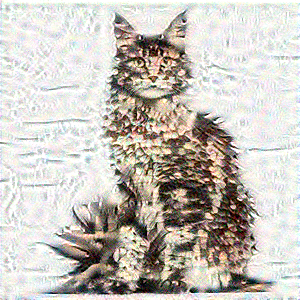

In [107]:
show_tensor(generated_image)